In [29]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [30]:
!pip install torchsummary

In [31]:
from torchsummary import summary

## Часть 1. Подготовка данных (1 балл)

Загрузим изображения. Напишем функцию, которая строит DataLoader для изображений, изменяя их размер до 128

In [32]:
def get_dataloader(image_size, batch_size):
    """
    Builds dataloader for training data.
    Use tt.Compose and tt.Resize for transformations
    :param image_size: height and wdith of the image
    :param batch_size: batch_size of the dataloader
    :returns: DataLoader object 
    """
    DATA_DIR = '/kaggle/input/faces-dataset-small'

    train_ds = ImageFolder(
        root=DATA_DIR, 
        transform=tt.Compose([
            tt.Resize(image_size),
            tt.CenterCrop(image_size),
            tt.ToTensor(),
            tt.Normalize(*stats)]
        )
    )
    train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
    
    return train_dl

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [33]:
image_size = 128
batch_size = 16
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_dl = get_dataloader(image_size, batch_size)

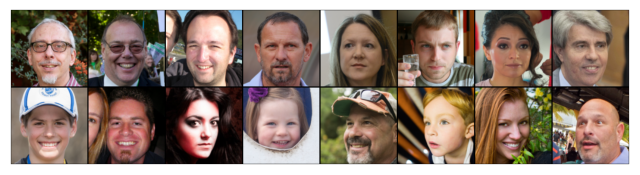

In [34]:
show_batch(train_dl)

## Часть 2. Построение и обучение модели (2 балла)

In [35]:
#  добавляем Гауссов шум

class GaussianNoise(nn.Module): 
    
    def __init__(self, std=0.3):
        super().__init__()
        self.std = std

    def forward(self, x):
        if self.training:
            return x + torch.empty_like(x).normal_(std=self.std)
        else:
            return x

In [36]:
# параметры discriminator и generator

std = 0.1
latent_size = 128
nc=3
ngf=64
ndf=64
kernel_size=4
batchNorm_momentum=0.1

In [37]:
discriminator = nn.Sequential(

        # input
        GaussianNoise(std),
        nn.Conv2d(in_channels=nc, out_channels=ndf, kernel_size=kernel_size, stride=2, padding=1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        
        # second layer
        GaussianNoise(std),
        nn.Conv2d(in_channels=ndf, out_channels=ndf * 2, kernel_size=kernel_size, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=ndf *2, momentum = batchNorm_momentum),
        nn.LeakyReLU(0.2, inplace=True),
        
        # third layer
        GaussianNoise(std),
        nn.Conv2d(in_channels=ndf * 2, out_channels=ndf * 4, kernel_size=kernel_size, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=ndf * 4, momentum = batchNorm_momentum),
        nn.LeakyReLU(0.2, inplace=True),
        
        # fourth layer
        GaussianNoise(std),
        nn.Conv2d(in_channels=ndf * 4, out_channels=ndf * 8, kernel_size=kernel_size, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=ndf * 8, momentum = batchNorm_momentum),
        nn.LeakyReLU(0.2, inplace=True),

        # fifth layer
        GaussianNoise(std),
        nn.Conv2d(in_channels=ndf * 8, out_channels=ndf * 16, kernel_size=kernel_size, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=ndf * 16, momentum = batchNorm_momentum),
        nn.LeakyReLU(0.2, inplace=True),
        
        # output
        GaussianNoise(std),
        nn.Conv2d(in_channels=ndf * 16, out_channels=1, kernel_size=kernel_size, stride=1, padding=0, bias=False),
        nn.Flatten(),
        nn.Sigmoid()
)

In [38]:
generator = nn.Sequential(

        # input
        nn.ConvTranspose2d(in_channels=latent_size, out_channels=ngf * 16, kernel_size=kernel_size, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(num_features=ngf*16, momentum = batchNorm_momentum),
        nn.LeakyReLU(0.2, inplace=True),

        # second layer
        nn.ConvTranspose2d(in_channels=ngf * 16, out_channels=ngf * 8, kernel_size=kernel_size, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=ngf*8, momentum = batchNorm_momentum),
        nn.LeakyReLU(0.2, inplace=True),
        
        # third layer
        nn.ConvTranspose2d(in_channels=ngf*8, out_channels=ngf*4, kernel_size=kernel_size, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=ngf*4, momentum = batchNorm_momentum),
        nn.LeakyReLU(0.2, inplace=True),
        
        # fourth layer
        nn.ConvTranspose2d(in_channels=ngf * 4, out_channels=ngf*2, kernel_size=kernel_size, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=ngf*2, momentum = batchNorm_momentum),
        nn.LeakyReLU(0.2, inplace=True),

        # fifth layer
        nn.ConvTranspose2d(in_channels=ngf*2, out_channels=ngf, kernel_size=kernel_size, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=ngf, momentum = batchNorm_momentum),
        nn.LeakyReLU(0.2, inplace=True),

        # output
        nn.ConvTranspose2d(in_channels=ngf, out_channels=nc, kernel_size=kernel_size, stride=2, padding=1, bias=False),
        nn.Tanh()
    )

In [39]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [40]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [41]:
discriminator = to_device(discriminator, device)
generator = to_device(generator, device)

In [42]:
summary(discriminator, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
     GaussianNoise-1          [-1, 3, 128, 128]               0
            Conv2d-2           [-1, 64, 64, 64]           3,072
         LeakyReLU-3           [-1, 64, 64, 64]               0
     GaussianNoise-4           [-1, 64, 64, 64]               0
            Conv2d-5          [-1, 128, 32, 32]         131,072
       BatchNorm2d-6          [-1, 128, 32, 32]             256
         LeakyReLU-7          [-1, 128, 32, 32]               0
     GaussianNoise-8          [-1, 128, 32, 32]               0
            Conv2d-9          [-1, 256, 16, 16]         524,288
      BatchNorm2d-10          [-1, 256, 16, 16]             512
        LeakyReLU-11          [-1, 256, 16, 16]               0
    GaussianNoise-12          [-1, 256, 16, 16]               0
           Conv2d-13            [-1, 512, 8, 8]       2,097,152
      BatchNorm2d-14            [-1, 51

In [43]:
model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [45]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            real_images = real_images.to(device)
            
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
    return losses_g, losses_d, real_scores, fake_scores

In [46]:
epochs = 50
lr = 2e-4
GAN_history = fit(model, criterion, epochs, lr)

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 5.2217, loss_d: 1.0182, real_score: 0.7282, fake_score: 0.2748


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 2.2624, loss_d: 1.2172, real_score: 0.6279, fake_score: 0.3761


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 2.1892, loss_d: 1.2306, real_score: 0.6124, fake_score: 0.3838


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 2.2098, loss_d: 1.2013, real_score: 0.6125, fake_score: 0.3827


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 2.5813, loss_d: 1.1156, real_score: 0.6382, fake_score: 0.3560


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 2.7193, loss_d: 1.0189, real_score: 0.6680, fake_score: 0.3254


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 2.9873, loss_d: 1.0183, real_score: 0.6710, fake_score: 0.3214


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 3.1694, loss_d: 0.9201, real_score: 0.7031, fake_score: 0.2947


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 3.2303, loss_d: 0.9025, real_score: 0.7084, fake_score: 0.2879


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 3.1375, loss_d: 0.9199, real_score: 0.7067, fake_score: 0.2911


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 3.0144, loss_d: 0.8997, real_score: 0.7111, fake_score: 0.2882


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 3.0027, loss_d: 0.8796, real_score: 0.7154, fake_score: 0.2801


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 2.8752, loss_d: 0.8811, real_score: 0.7139, fake_score: 0.2861


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 2.8787, loss_d: 0.9037, real_score: 0.7115, fake_score: 0.2855


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 2.7522, loss_d: 0.8932, real_score: 0.7121, fake_score: 0.2864


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 2.7711, loss_d: 0.8726, real_score: 0.7206, fake_score: 0.2790


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 2.7679, loss_d: 0.8402, real_score: 0.7253, fake_score: 0.2709


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 2.7279, loss_d: 0.8562, real_score: 0.7255, fake_score: 0.2721


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 2.7193, loss_d: 0.8380, real_score: 0.7309, fake_score: 0.2711


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 2.6760, loss_d: 0.8579, real_score: 0.7264, fake_score: 0.2686


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 2.7508, loss_d: 0.7859, real_score: 0.7417, fake_score: 0.2590


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 2.7261, loss_d: 0.8362, real_score: 0.7337, fake_score: 0.2639


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 2.7167, loss_d: 0.7571, real_score: 0.7515, fake_score: 0.2467


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 2.9129, loss_d: 0.7777, real_score: 0.7501, fake_score: 0.2462


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 2.9166, loss_d: 0.7471, real_score: 0.7589, fake_score: 0.2411


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 3.0336, loss_d: 0.7064, real_score: 0.7647, fake_score: 0.2337


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 2.8841, loss_d: 0.7175, real_score: 0.7663, fake_score: 0.2315


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 2.9712, loss_d: 0.7591, real_score: 0.7609, fake_score: 0.2397


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 2.8791, loss_d: 0.6857, real_score: 0.7739, fake_score: 0.2238


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 2.9758, loss_d: 0.6340, real_score: 0.7901, fake_score: 0.2089


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 3.0152, loss_d: 0.6533, real_score: 0.7879, fake_score: 0.2104


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 3.1312, loss_d: 0.6533, real_score: 0.7891, fake_score: 0.2091


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 3.2281, loss_d: 0.5987, real_score: 0.8033, fake_score: 0.1967


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 3.1720, loss_d: 0.6178, real_score: 0.7997, fake_score: 0.1985


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 3.2442, loss_d: 0.6321, real_score: 0.8016, fake_score: 0.1980


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 3.2763, loss_d: 0.5436, real_score: 0.8180, fake_score: 0.1806


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 3.5277, loss_d: 0.5585, real_score: 0.8178, fake_score: 0.1798


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 3.3866, loss_d: 0.5613, real_score: 0.8207, fake_score: 0.1779


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 3.5351, loss_d: 0.5633, real_score: 0.8173, fake_score: 0.1825


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 3.5540, loss_d: 0.4710, real_score: 0.8413, fake_score: 0.1575


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 3.6008, loss_d: 0.5302, real_score: 0.8305, fake_score: 0.1682


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 3.5034, loss_d: 0.4973, real_score: 0.8364, fake_score: 0.1603


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [43/50], loss_g: 3.6265, loss_d: 0.4973, real_score: 0.8416, fake_score: 0.1587


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 3.7051, loss_d: 0.3800, real_score: 0.8678, fake_score: 0.1324


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 3.9342, loss_d: 0.4241, real_score: 0.8579, fake_score: 0.1388


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 3.8995, loss_d: 0.4378, real_score: 0.8602, fake_score: 0.1415


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 3.9141, loss_d: 0.4934, real_score: 0.8489, fake_score: 0.1500


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 3.8745, loss_d: 0.3377, real_score: 0.8815, fake_score: 0.1189


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 4.1712, loss_d: 0.4058, real_score: 0.8680, fake_score: 0.1311


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 4.1113, loss_d: 0.3831, real_score: 0.8719, fake_score: 0.1258


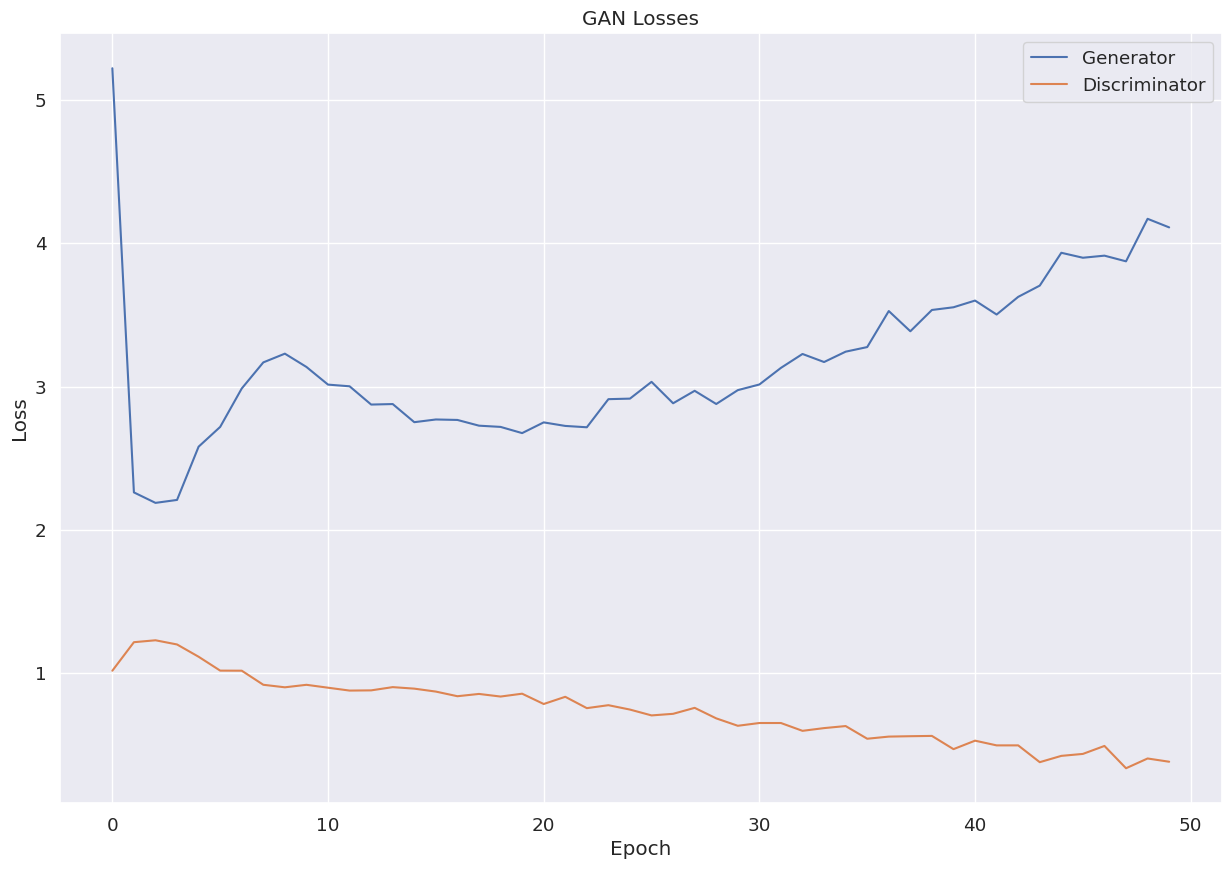

In [47]:
plt.plot(GAN_history[0], label='Generator');
plt.plot(GAN_history[1], label='Discriminator');
plt.legend();
plt.xlabel('Epoch');
plt.ylabel('Loss');
plt.title('GAN Losses');

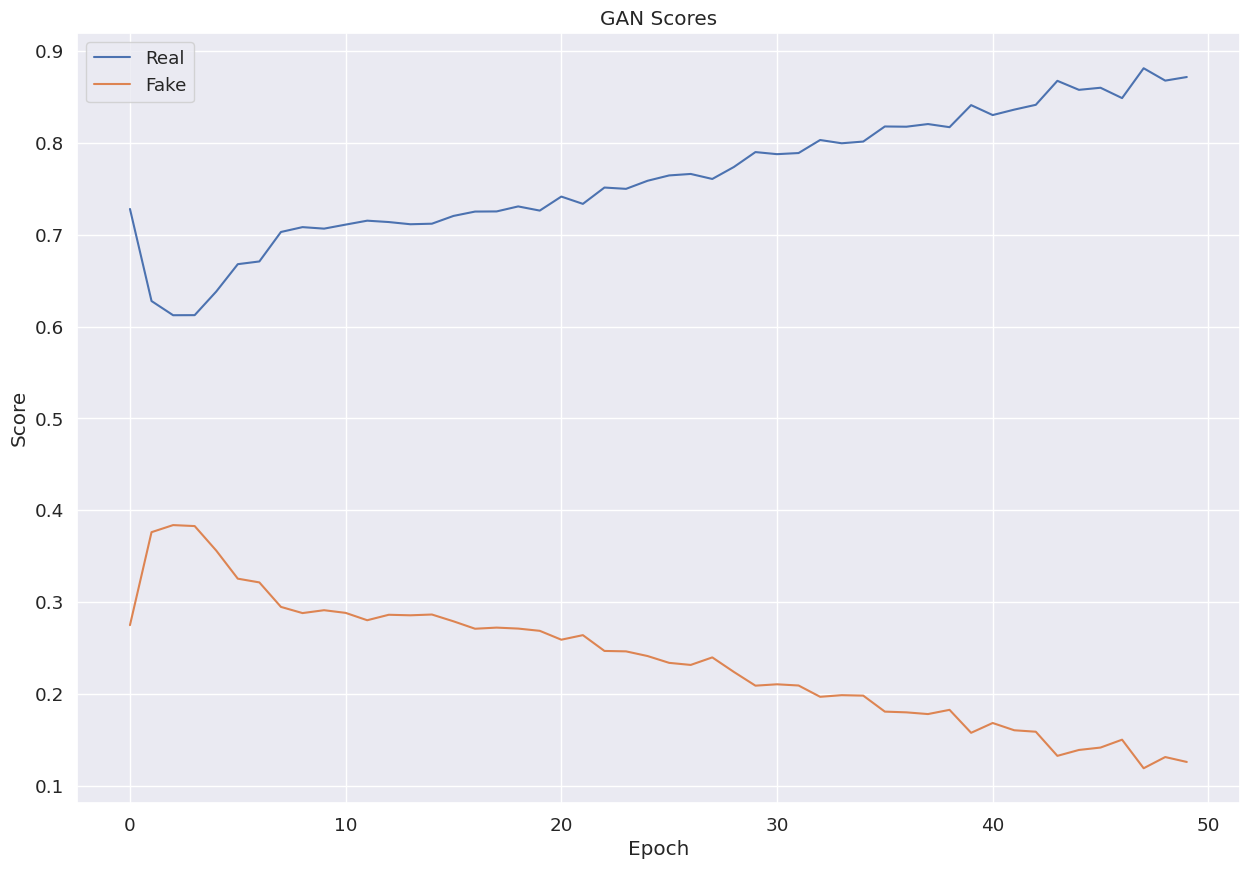

In [48]:
plt.plot(GAN_history[2], label='Real');
plt.plot(GAN_history[3], label='Fake');
plt.legend();
plt.xlabel('Epoch');
plt.ylabel('Score');
plt.title('GAN Scores');

Значения лосс-функции генератора больше значений дискриминатора.

## Часть 3. Генерация изображений (1 балл)

In [49]:
n_images = 32

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

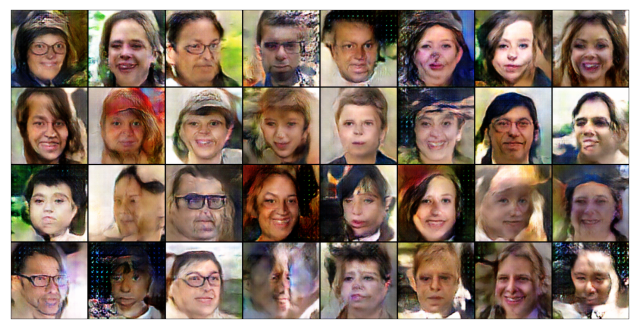

In [50]:
show_images(fake_images.cpu(), n_images)

Генерация фейковых лиц достаточно близка к реальным лицам. Полных копий нет. Отдельные детали лица прорисованы достаточно точно.

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

In [51]:
# возьмем 2000 реальных изображений и сгенерируем еще 2000

n_images = 2000

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
model["generator"].eval()
fake_images = model["generator"].to(device)(fixed_latent)
real_images = next(iter(get_dataloader(image_size, n_images)))[0]

In [52]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

zeros = torch.zeros(n_images, 1, device='cpu')
ones = torch.ones(n_images, 1, device='cpu')

X = torch.cat((fake_images.cpu(), real_images.cpu())).detach().numpy().reshape(-1, 3*image_size*image_size)
y = torch.cat((zeros, ones)).detach().numpy()

knc = KNeighborsClassifier(n_neighbors=1)
loo = LeaveOneOut()

accuracy_score_history = []
predictions = []
targets = []
for train_index, test_index in tqdm(loo.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    knc.fit(X_train, np.ravel(y_train))
    pred = knc.predict(X_test)
    accuracy_score_history.append(accuracy_score(pred, y_test))
    predictions.append(pred)
    targets.append(y_test)

0it [00:00, ?it/s]

Mean accuracy = 0.72475


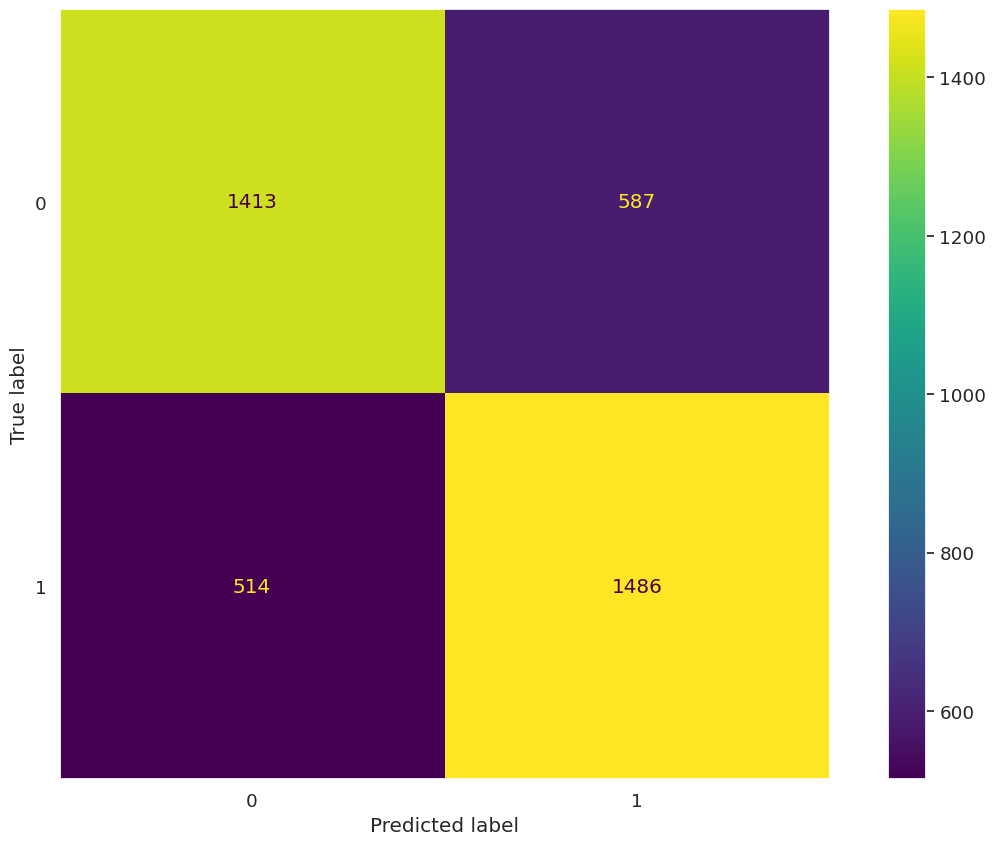

In [53]:
print('Mean accuracy =', np.mean(accuracy_score_history))

cm =  confusion_matrix([t.item() for t in targets],
                       [p.item() for p in predictions])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.grid(False)
plt.show()

Идеальная accuracy равна 0.5 (фейки невозможно отличить от реальных фото). Полученное значение accuracy 0.72 стремится к идеалу, но не достигает его. Для лучшей генерации необходимо использовать более сложную архитектуру, обучать большее количество эпох.

### 4.2. Визуализация распределений (2 балла)

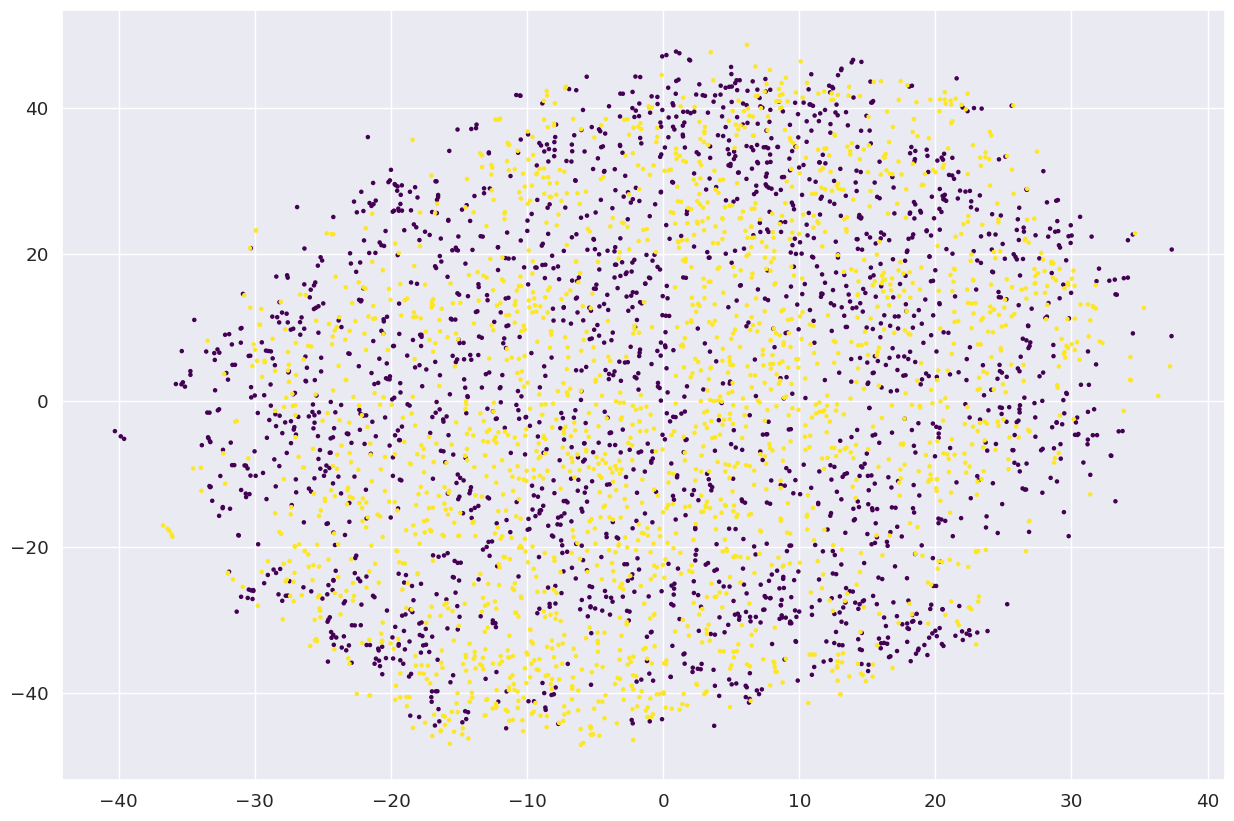

In [54]:
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(X)

x1, x2 = zip(*X_embedded)
plt.scatter(x1, x2, c=y, s=5, cmap='viridis')

Полученное TSNE-распределение не позволяет однозначно кластеризовать классы друг относительно друга. Равномерное распределение классов фейковых и реальных изображений говорит об их высоком уровне схожести.